In [17]:
## Project title: Predicting students Mathematics performance using machine learning models

######################################################################################
# 1. Load the necessary packages
######################################################################################

# Data processing
import pandas as pd
import numpy as np
import random as rn

# Standardize the data
from sklearn.preprocessing import StandardScaler

# Modeling 
import tensorflow as tf
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE   ## to help with extreme imbalances in outcome variables for classification models.
from sklearn.linear_model import LogisticRegression                        ## For Logistic regression
from sklearn.linear_model import LogisticRegressionCV                      ## For Logistic regression CV
from sklearn.ensemble import GradientBoostingClassifier                    ## for GB classification
from sklearn.tree import DecisionTreeClassifier                            ## for DT classification
from sklearn.ensemble import RandomForestClassifier                        ## for RF classification
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV            ## for regularization
from sklearn.linear_model import lasso_path                                ## for lasso coef path
from sklearn.svm import SVC                                                ## for support vector classification
from sklearn.preprocessing import label_binarize

# Hyperparameter tuning
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score

# Plot
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay    ## For confusipn matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Model evaluation
from sklearn.metrics import roc_curve, classification_report, confusion_matrix, auc, roc_auc_score, accuracy_score ## for classification
from sklearn import metrics

In [7]:
######################################################################################
## 2. Data import and pre-processing
######################################################################################
dat = pd.read_csv('GP_school_data.csv')
print(dat.shape)  ## check the shape of the data
#print(dat.columns) 


## selecting the variables of interest
## I was analysing the data in R-Studio, so most of the dummy coding and recoding and other cleaning have been made.
dat_1 = dat.drop(['school','address','sex', 'Medu','Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime',
                 'freetime', 'goout', 'Dalc','romantic', 'famsize', 'mom_home', 'mom_health', 'mom_other', 'mom_services',
                  'mom_teacher', 'dad_home', 'dad_health','dad_other', 'dad_services','dad_teacher',  
                  'less_fifteen', 'fifteen_and_thirty','thirty_to_hour', 'more_than_hour', 'Walc', 'Dalc', 
                  'Pstatus', 'studytime'], axis=1)


## recoding the binary variables from yes/no to 1/0
## First confirming the values 
yes_no_columns = ['schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet']
#for col in yes_no_columns:
#    print(dat_1[col].value_counts())
    
## Now, recoding   
def recode(col):
    return col.map({'yes': 1, 'no': 0})
dat_1[yes_no_columns] = dat_1[yes_no_columns].apply(recode)

print(dat_1[['schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet']].describe())

## creating thre datasets for each outcome (i.e., the continuous, binary, and multi-categorical)
dat_continuous = dat_1.drop(['G3_binary', 'G3_ordinal'], axis =1)
dat_binary = dat_1.drop(['G3', 'G3_ordinal'], axis =1)
dat_ordinal = dat_1.drop(['G3', 'G3_binary'], axis =1)
print(dat_1.shape)
print(dat_continuous.shape)
print(dat_binary.shape)
print(dat_ordinal.shape)
print(dat_1.columns)

(349, 71)
        schoolsup      famsup        paid  activities     nursery      higher  \
count  349.000000  349.000000  349.000000  349.000000  349.000000  349.000000   
mean     0.146132    0.641834    0.461318    0.530086    0.808023    0.951289   
std      0.353745    0.480150    0.499217    0.499811    0.394421    0.215571   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    1.000000    1.000000   
50%      0.000000    1.000000    0.000000    1.000000    1.000000    1.000000   
75%      0.000000    1.000000    1.000000    1.000000    1.000000    1.000000   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

         internet  
count  349.000000  
mean     0.851003  
std      0.356597  
min      0.000000  
25%      1.000000  
50%      1.000000  
75%      1.000000  
max      1.000000  
(349, 39)
(349, 37)
(349, 37)
(349, 37)
Index(['age', 'failures', 'schoolsup', '

In [140]:
######################################################################################
# 4. Data split and standardization for the continuous outcome
######################################################################################
# seed for reproducibility
seed = 999

## The below is necessary for starting Numpy generated random numbers
## in a well-defined initial state.
np.random.seed(seed)

# Train (80%) and test (20%) set split (For the contregress)
# Make separate data set for Y and X
Y_bin = dat_ordinal['G3_ordinal']
X_bin = dat_ordinal.drop(['G3_ordinal'], axis=1)

print(f'The dependent (Y) dataset has {Y_bin.shape}.')
print(f'The independent (X) dataset has {X_bin.shape}.')

# Splitting the dataset into train and test sets
X_train, X_test, y_train, y_test  = train_test_split( X_bin, Y_bin, test_size = 0.2, random_state = 42)

print(f'The training dataset has {len(X_train)} observations')
print(f'The test dataset has {len(X_test)} observations')

# Standardization of continuous variable.
# VERY IMPORTANT: to avoid any information leaking from testing data to training data, we do standardization separately. 
# define continuous variable columns
continuous_vars = ['age', 'famrel', 'health', 'G1', 'G2', 'famrel']
scaler = StandardScaler()
X_train[continuous_vars] = scaler.fit_transform(X_train[continuous_vars])
X_test[continuous_vars] = scaler.fit_transform(X_test[continuous_vars])
print(X_train[continuous_vars].describe())
print(X_test[continuous_vars].describe())

## checking the dimension of data
print(f'The training dataset has {X_train.shape}')
print(f'The test dataset has {X_test.shape}')

The dependent (Y) dataset has (349,).
The independent (X) dataset has (349, 36).
The training dataset has 279 observations
The test dataset has 70 observations
                age        famrel        health            G1            G2  \
count  2.790000e+02  2.790000e+02  2.790000e+02  2.790000e+02  2.790000e+02   
mean   1.655386e-16  1.368877e-16 -6.048527e-17  3.501779e-17 -2.355742e-16   
std    1.001797e+00  1.001797e+00  1.001797e+00  1.001797e+00  1.001797e+00   
min   -1.291384e+00 -3.502358e+00 -1.891300e+00 -2.314836e+00 -2.701073e+00   
25%   -4.725290e-01  5.525565e-02 -4.336407e-01 -8.450152e-01 -4.273907e-01   
50%   -4.725290e-01  5.525565e-02  2.951891e-01  3.687722e-02  7.787204e-02   
75%    3.463256e-01  6.481913e-01  1.024019e+00  6.248055e-01  5.831348e-01   
max    4.440599e+00  1.241127e+00  1.024019e+00  2.388590e+00  2.098923e+00   

             famrel  
count  2.790000e+02  
mean   1.368877e-16  
std    1.001797e+00  
min   -3.502358e+00  
25%    5.525565e-0

G3_ordinal
1    113
2     89
4     56
3     54
5     37
Name: count, dtype: int64
G3_ordinal
1    95
2    67
4    44
3    43
5    30
Name: count, dtype: int64


/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


The Accuracy is 0.61

Classification Report:
              precision    recall  f1-score   support

           1       0.76      0.89      0.82        18
           2       0.62      0.59      0.60        22
           3       0.36      0.36      0.36        11
           4       0.60      0.50      0.55        12
           5       0.57      0.57      0.57         7

    accuracy                           0.61        70
   macro avg       0.58      0.58      0.58        70
weighted avg       0.61      0.61      0.61        70



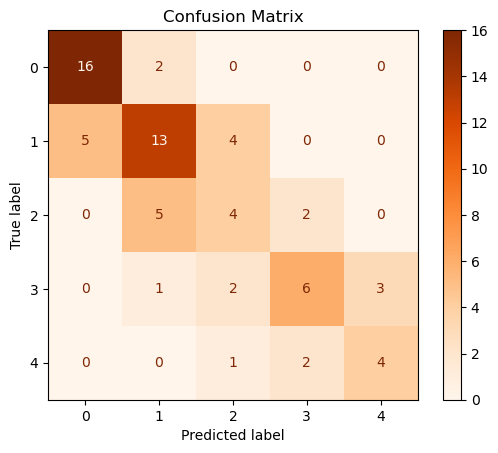

In [45]:
######################################################################################
# 5. Model building (logistic regression)
######################################################################################
# creating new datasets for this analysis
x_test_mult = X_test
y_test_mult = y_test

# Define the logistic regression model
multi_mod = LogisticRegression(max_iter=20000,
                                penalty = 'none',
                                multi_class='multinomial',
                                random_state = 42,
                                solver = 'sag')



print(Y_bin.value_counts()) ## 236 are ones, and only 113  are 0, showing huge imbalance in the FULL DATA
print(y_train.value_counts()) ## 184 are ones, and only 95  are 0, showing huge imbalance in the training set

# Synthetic Minority Oversampling Technique (SMOTE) in training data
# (useful when the is a vast imbalance in the outcome variable)
sm = SMOTE(random_state = 2)
x_train_mult , y_train_mult  = sm.fit_resample(X_train, y_train)


# Fit the model
multi_mod.fit(x_train_mult, y_train_mult)


######################################################################################
# evaluating the model
######################################################################################
# predicted class
y_pred_mult = multi_mod.predict(x_test_mult) ## predicted class

## Accuracy
accuracy_mult = accuracy_score(y_test_mult, y_pred_mult)
print(f'The Accuracy is {accuracy_mult:.2f}')

# Calculate the confusion matrix
cm_mult = confusion_matrix(y_test_mult, y_pred_mult)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test_mult, y_pred_mult))

## Confusion matrix
conf_mult = ConfusionMatrixDisplay(confusion_matrix=cm_mult)
conf_mult.plot(cmap=plt.cm.Oranges)
plt.title("Confusion Matrix")
plt.show()


Accuracy: 0.59


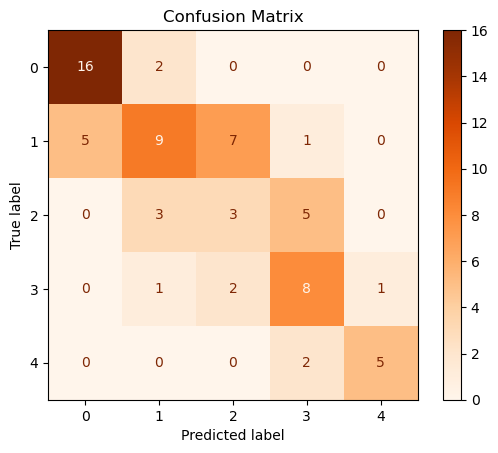

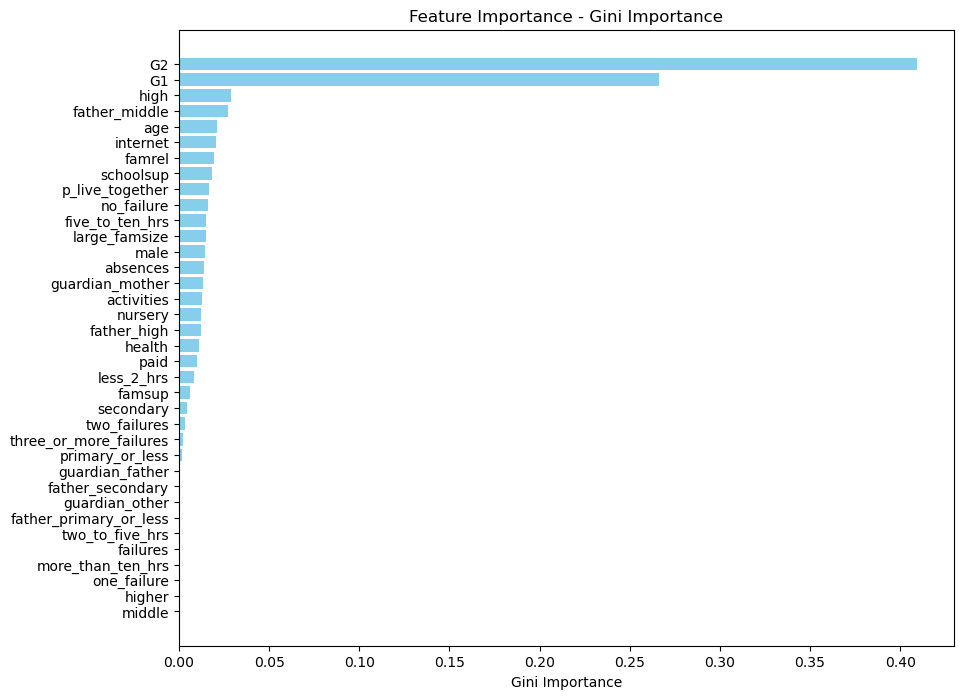

In [58]:
######################################################################################
# Decision tree classifier
######################################################################################
# creating new datasets for this analysis
x_test_dt = X_test
y_test_dt = y_test

# The DT classifier
dt = DecisionTreeClassifier()

# Hyperparameter search for GB.
dt_param_grid = {
    'criterion':  ['gini', 'entropy'],
    'max_depth':  [None, 2, 4, 6, 8, 10, 20, 30, 50, 100],
    'max_features': [None, 'sqrt', 'log2', 0.2, 0.4, 0.6, 0.8],
    'splitter': ['best', 'random']
    }

# Instantiate the grid search model
# change verbose to any interger if you want to print out the message
dt_grid_search = GridSearchCV(estimator=dt, param_grid=dt_param_grid, n_jobs = -1, cv = 10, verbose=False)

# SMOTE in training data (Ensures a hypothetical balance between the binary variable)
sm = SMOTE(random_state=2)
x_train_dt, y_train_dt = sm.fit_resample(X_train, y_train)

# Fit the model using training data after SMOTE
dt_grid_search.fit(x_train_dt, y_train_dt)

dt_best_grid = dt_grid_search.best_estimator_
dt_best_params = dt_grid_search.best_params_


######################################################################################
# Model evaluation and plotting
######################################################################################

## predicted classes (binary. 0 and 1)
y_hat_dt = dt_best_grid.predict(x_test_dt)  

# Calculate the confusion matrix
cm_dt = confusion_matrix(y_test_dt, y_hat_dt)

# Calculate accuracy
accuracy_dt = accuracy_score(y_test_dt, y_hat_dt)

# Print Accuracy
print(f"Accuracy: {accuracy_dt:.2f}") #

## Confusion matrix
conf_dt = ConfusionMatrixDisplay(confusion_matrix=cm_dt)
conf_dt.plot(cmap=plt.cm.Oranges)
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test_dt, y_hat_dt))


# Let's get variable importance
## Getting feature names from training data
feature_names_dt = x_test_dt.columns  

## Get feature importances
importances_dt = dt_best_grid.feature_importances_

## Create a DataFrame for display
feature_imp_dt = pd.DataFrame({
    'Feature': feature_names_dt,
    'Gini Importance': importances_dt
}).sort_values('Gini Importance', ascending=False)
#print(feature_imp_dt)

## Plot the feature importances
plt.figure(figsize=(10, 8))
plt.barh(feature_imp_dt['Feature'], feature_imp_dt['Gini Importance'], color='skyblue')
plt.xlabel('Gini Importance')
plt.title('Feature Importance - Gini Importance')
plt.gca().invert_yaxis()
plt.show()

Accuracy: 0.69


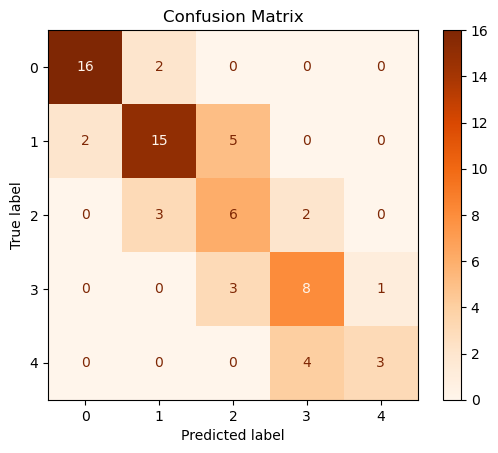

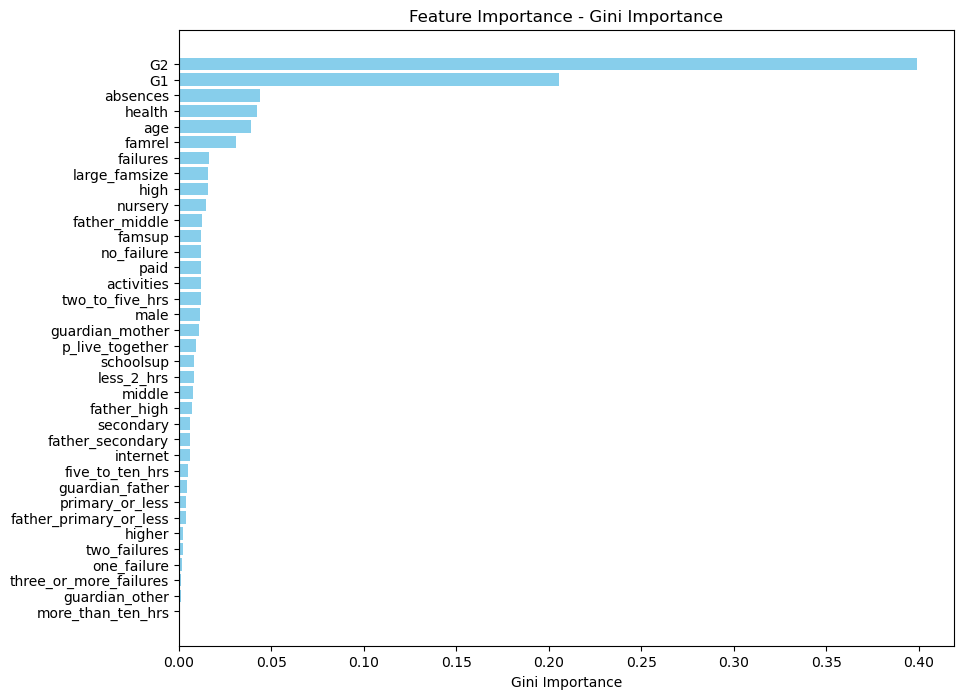

In [67]:
######################################################################################
# 4. Random forest
######################################################################################
# creating new datasets for this analysis
x_test_rf = X_test
y_test_rf = y_test

rf = RandomForestClassifier()

# Hyperparameter search (tunning) for RF.
rf_param_grid = {
    'max_depth': [20, 30],
    'max_features': [2, 3, 4, 5, 8,10], 
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [3, 4, 5],
    'n_estimators': [100, 200, 300]  
    }    

# Instantiate the grid search model
rf_grid_search = GridSearchCV (estimator = rf, param_grid = rf_param_grid, cv = 5, n_jobs = -1, verbose = False)


# Synthetic Minority Oversampling Technique (SMOTE) in training data
sm = SMOTE(random_state = 2)
x_train_rf, y_train_rf = sm.fit_resample(X_train, y_train)

# Fit the model using training data after SMOTE
rf_grid_search.fit(x_train_rf, y_train_rf)


# Get the best model and its corresponding hyperparameters
rf_best_grid = rf_grid_search.best_estimator_
rf_best_params = rf_grid_search.best_params_


######################################################################################
# Model evaluation
######################################################################################
# predicted class
y_hat_rf = rf_best_grid.predict(x_test_rf)

# Calculate the confusion matrix
cm_rf = confusion_matrix(y_test_rf, y_hat_rf)

# Calculate accuracy
accuracy_rf = accuracy_score (y_hat_rf, y_test_rf)
print(f"Accuracy: {accuracy_rf:.2f}")

## Confusion matrix
conf_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf)
conf_rf.plot(cmap=plt.cm.Oranges)
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test_rf, y_hat_rf))

## Let's get variable importance
## Getting feature names from training data
feature_names_rf = x_test_rf.columns  

## Get feature importances
importances_rf = rf_best_grid.feature_importances_

## Create a DataFrame for display
feature_imp_rf = pd.DataFrame({
    'Feature': feature_names_rf,
    'Gini Importance': importances_rf
}).sort_values('Gini Importance', ascending=False)
#print(feature_imp_df)

## Plot the feature importances
plt.figure(figsize=(10, 8))
plt.barh(feature_imp_rf['Feature'], feature_imp_rf['Gini Importance'], color='skyblue')
plt.xlabel('Gini Importance')
plt.title('Feature Importance - Gini Importance')
plt.gca().invert_yaxis()
plt.show()


Accuracy: 0.71


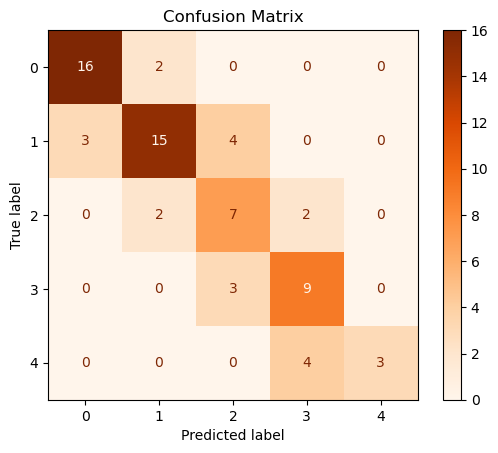

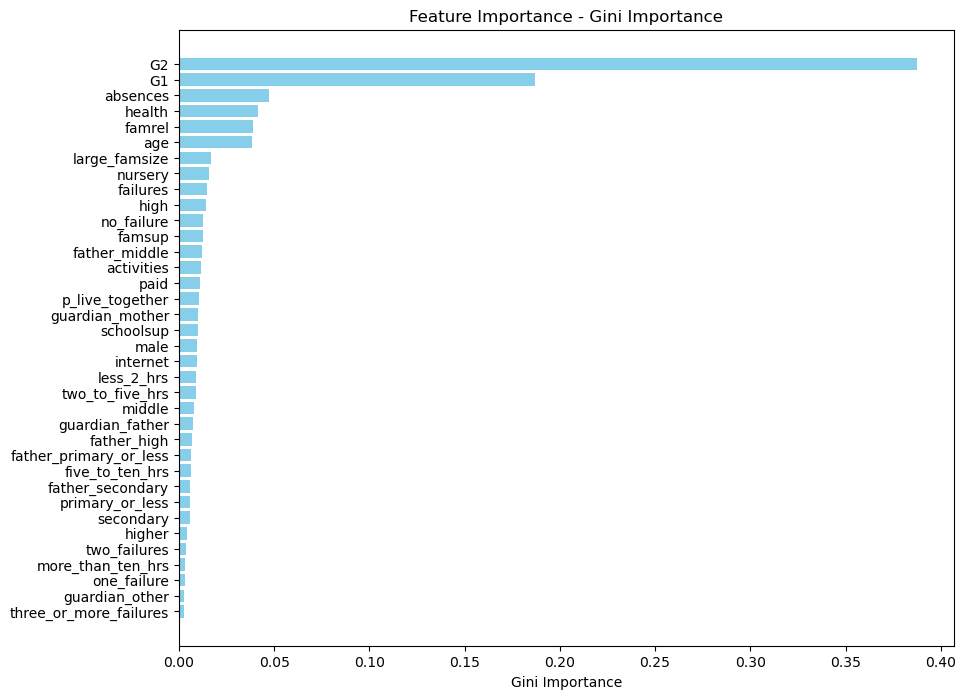

In [76]:
######################################################################################
#  Gradient Boosting Model building
######################################################################################
# creating new datasets for this analysis
x_test_gb = X_test
y_test_gb = y_test

## The Gradient boosting Model
gb = GradientBoostingClassifier()

# Hyperparameter search for GB.
gb_param_grid = {
    "n_estimators":[50, 100, 300],  
    "max_depth":[1, 3, 5, 10],     
    "learning_rate":[0.01,0.1, 0.5],  
    "subsample": [0.5,0.8, 1.0], 
    "min_samples_split": [2, 5, 10],  
    "max_features": ['log2', 'sqrt'],
    "min_impurity_decrease": [ 0.3, 0.1, 0.08]
    }

# Activate the grid search model
gb_grid_search = GridSearchCV(estimator=gb, param_grid=gb_param_grid, n_jobs = -1, cv = 5, verbose=False)

# SMOTE in training data
sm = SMOTE(sampling_strategy='auto',random_state=2)
x_train_gb, y_train_gb = sm.fit_resample(X_train, y_train)

# Fit the model using training data after SMOTE
gb_grid_search.fit(x_train_gb, y_train_gb)

gb_best_grid = gb_grid_search.best_estimator_
gb_best_params = gb_grid_search.best_params_


######################################################################################
# Model evaluation and plotting
######################################################################################
## predicted class
y_hat_gb = gb_best_grid.predict(x_test_gb)

# Calculate the confusion matrix
cm_gb = confusion_matrix(y_test_gb, y_hat_gb)

# Calculate accuracy
accuracy_gb = accuracy_score (y_hat_gb, y_test_gb)
print(f"Accuracy: {accuracy_gb:.2f}") #


# Classification Report
print("\nClassification Report:")
print(classification_report(y_test_gb, y_hat_gb))

## Confusion matrix
conf_gb = ConfusionMatrixDisplay(confusion_matrix=cm_gb)
conf_gb.plot(cmap=plt.cm.Oranges)
plt.title("Confusion Matrix")
plt.show()


## Let's get variable importance
## Getting feature names from training data
feature_names_gb = x_test_gb.columns  

## Get feature importances
importances_gb = gb_best_grid.feature_importances_

## Create a DataFrame for display
feature_imp_gb = pd.DataFrame({
    'Feature': feature_names_gb,
    'Gini Importance': importances_gb
}).sort_values('Gini Importance', ascending=False)
#print(feature_imp_gbr)

## Plot the feature importances
plt.figure(figsize=(10, 8))
plt.barh(feature_imp_gb['Feature'], feature_imp_gb['Gini Importance'], color='skyblue')
plt.xlabel('Gini Importance')
plt.title('Feature Importance - Gini Importance')
plt.gca().invert_yaxis()
plt.show()


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Accuracy     : 0.7429

Classification Report:
              precision    recall  f1-score   support

           1       0.89      0.89      0.89        18
           2       0.75      0.68      0.71        22
           3       0.46      0.55      0.50        11
           4       0.71      0.83      0.77        12
           5       1.00      0.71      0.83         7

    accuracy                           0.74        70
   macro avg       0.76      0.73      0.74        70
weighted avg       0.76      0.74      0.75        70



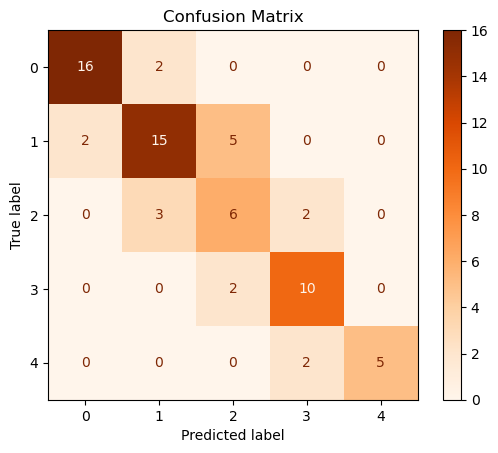

In [85]:
#############################################################
## Support Vector Machine (SVM)
#############################################################
# creating new datasets for this analysis
x_test_svc = X_test
y_test_svc = y_test

# SVC
svc = SVC(probability = True, 
          decision_function_shape = 'ovr',
          random_state = 42)

# Parameter grid
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['rbf'],
    'gamma': ['scale', 0.01, 0.1, 1]
}

seed = 42
cv = KFold(n_splits=5, shuffle=True, random_state = seed)

# Grid search with reproducible splits
grid_search = GridSearchCV(
    estimator=svc,
    param_grid=param_grid,
    cv=cv,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

# SMOTE in training data
sm = SMOTE(sampling_strategy='auto',random_state=2)
x_train_svc, y_train_svc = sm.fit_resample(X_train, y_train)

# The training model
svc_cv = grid_search.fit(x_train_svc, y_train_svc)

###########################################################################
#Test Set Evaluation
###########################################################################
best_svc = svc_cv.best_estimator_
y_hat_svc = best_svc.predict(x_test_svc)

## confusion matrix
cm_svc = confusion_matrix(y_test_svc, y_hat_svc)
accuracy_svc = accuracy_score(y_hat_svc, y_test_svc)
print(f"Accuracy     : {accuracy_svc:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test_svc, y_hat_svc))

#  Confusion Matrix Plot
## Confusion matrix
conf_svc = ConfusionMatrixDisplay(confusion_matrix=cm_svc)
conf_svc.plot(cmap=plt.cm.Oranges)
plt.title("Confusion Matrix")
plt.show()



Accuracy : 0.5714
Classification Report:
               precision    recall  f1-score   support

           1      0.875     0.778     0.824        18
           2      0.667     0.636     0.651        22
           3      0.250     0.273     0.261        11
           4      0.385     0.417     0.400        12
           5      0.500     0.571     0.533         7

    accuracy                          0.571        70
   macro avg      0.535     0.535     0.534        70
weighted avg      0.590     0.571     0.579        70



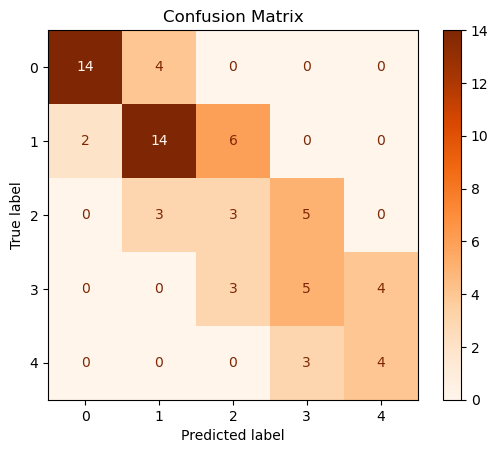

In [100]:
###########################################################################
#Lasso regression
###########################################################################
# creating new datasets for this analysis
x_test_lasso = X_test
y_test_lasso  = y_test

# Fit Lasso Logistic Regression
lasso_mod = LogisticRegressionCV(
    cv=5,
    penalty='l1',  ## 'l1' fpr Lasso penalty
    solver='saga',   # there are other options
    multi_class='multinomial',
    max_iter=10000,
    random_state=42
)

# SMOTE in training data
sm = SMOTE(sampling_strategy='auto',random_state=2)
x_train_lasso, y_train_lasso = sm.fit_resample(X_train, y_train)


# The training model
lasso_mod.fit(x_train_lasso , y_train_lasso)


# Prediction
y_hat_lasso  = lasso_mod.predict(x_test_lasso )               ## predicted class
y_proba_lasso  = lasso_mod.predict_proba(x_test_lasso )[:, 1]  ## Predicted probabilities  

# Evaluation
cm_lasso= confusion_matrix(y_test_lasso, y_hat_lasso)
accuracy_lasso= accuracy_score (y_hat_lasso, y_test_lasso)
print(f"Accuracy : {accuracy_lasso:.4f}")
print("Classification Report:\n", classification_report(y_test_lasso , y_hat_lasso , digits=3))  ## classification report


#  Confusion Matrix Plot
## Confusion matrix
conf_lasso = ConfusionMatrixDisplay(confusion_matrix=cm_lasso)
conf_lasso.plot(cmap=plt.cm.Oranges)
plt.title("Confusion Matrix")
plt.show()



Accuracy     : 0.6143
Classification Report:
               precision    recall  f1-score   support

           1      0.800     0.889     0.842        18
           2      0.667     0.636     0.651        22
           3      0.375     0.273     0.316        11
           4      0.417     0.417     0.417        12
           5      0.556     0.714     0.625         7

    accuracy                          0.614        70
   macro avg      0.563     0.586     0.570        70
weighted avg      0.601     0.614     0.605        70



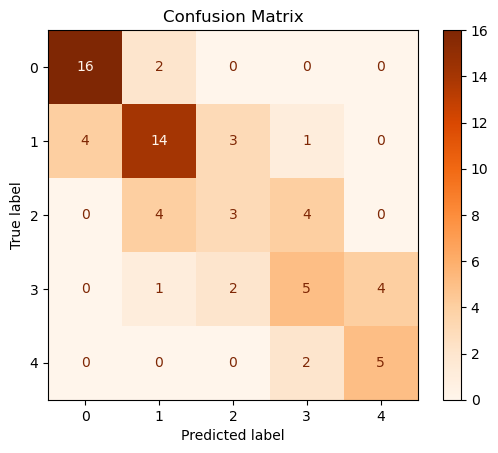

In [107]:
###########################################################################
#Ridge regression
###########################################################################
# creating new datasets for this analysis
x_test_ridge = X_test
y_test_ridge  = y_test

# Fit Ridge Logistic Regression
ridge_mod = LogisticRegressionCV(
    cv=5,
    penalty='l2',  ## 'l2' for Ridge penalty
    solver='saga',
    multi_class = 'multinomial',
    max_iter=50000,
    random_state=42
)

# SMOTE in training data
sm = SMOTE(sampling_strategy='auto',random_state=2)
x_train_ridge, y_train_ridge = sm.fit_resample(X_train, y_train)

# The training model
ridge_mod.fit(x_train_ridge , y_train_ridge)

# Prediction
y_hat_ridge  = ridge_mod.predict(x_test_ridge)               ## predicted class
y_proba_ridge  = ridge_mod.predict_proba(x_test_ridge)[:, 1]  ## Predicted probabilities  


# Evaluation
cm_ridge= confusion_matrix(y_test_ridge, y_hat_ridge)
accuracy_ridge = accuracy_score(y_test_ridge, y_hat_ridge)
print(f"Accuracy     : {accuracy_ridge:.4f}")
print("Classification Report:\n", classification_report(y_test_ridge, y_hat_ridge , digits=3))


#  Confusion Matrix Plot
## Confusion matrix
conf_ridge= ConfusionMatrixDisplay(confusion_matrix=cm_ridge)
conf_ridge.plot(cmap=plt.cm.Oranges)
plt.title("Confusion Matrix")
plt.show()


Accuracy     : 0.6000
Classification Report:
               precision    recall  f1-score   support

           1      0.882     0.833     0.857        18
           2      0.667     0.636     0.651        22
           3      0.250     0.273     0.261        11
           4      0.455     0.417     0.435        12
           5      0.556     0.714     0.625         7

    accuracy                          0.600        70
   macro avg      0.562     0.575     0.566        70
weighted avg      0.609     0.600     0.603        70



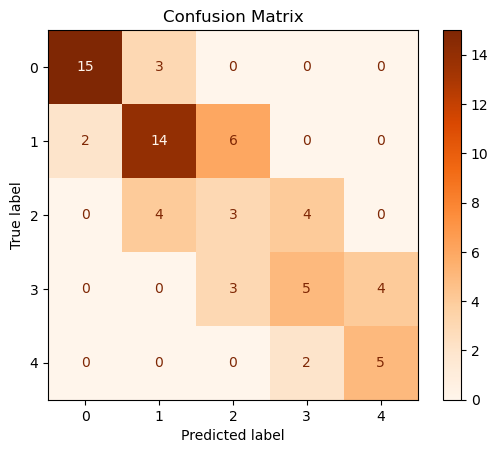

In [111]:
###########################################################################
# Elastic Net regression
###########################################################################
# creating new datasets for this analysis
x_test_enet = X_test
y_test_enet  = y_test

# Fit ENET Logistic Regression
enet_mod = LogisticRegressionCV(
    cv=5,
    penalty='elasticnet',  ## Elastic net
    solver='saga', 
    l1_ratios=[.07, .1, .5, .7, .9],  ## list of Elastic-Net mixing parameters
    max_iter=10000,
    random_state=22
)

# SMOTE in training data
sm = SMOTE(sampling_strategy="auto",random_state=2)
x_train_enet, y_train_enet = sm.fit_resample(X_train, y_train)

# The training model
enet_mod.fit(x_train_enet , y_train_enet)

# Prediction
y_hat_enet = enet_mod.predict(x_test_enet)               ## predicted class
y_proba_enet = enet_mod.predict_proba(x_test_enet)[:, 1]  ## Predicted probabilities  


# Evaluation
cm_enet= confusion_matrix(y_test_enet, y_hat_enet)
accuracy_enet = accuracy_score(y_test_enet, y_hat_enet)
print(f"Accuracy     : {accuracy_enet:.4f}")
print("Classification Report:\n", classification_report(y_test_enet, y_hat_enet, digits=3))


#  Confusion Matrix Plot
## Confusion matrix
conf_enet= ConfusionMatrixDisplay(confusion_matrix=cm_enet)
conf_enet.plot(cmap=plt.cm.Oranges)
plt.title("Confusion Matrix")
plt.show()

                 Model  Accuracy
0  Logistic Regression  0.614286
1                Lasso  0.571429
2                Ridge  0.614286
3           ElasticNet  0.600000
4        Decision Tree  0.585714
5        Random Forest  0.685714
6    Gradient Boosting  0.714286
7                  SVC  0.742857


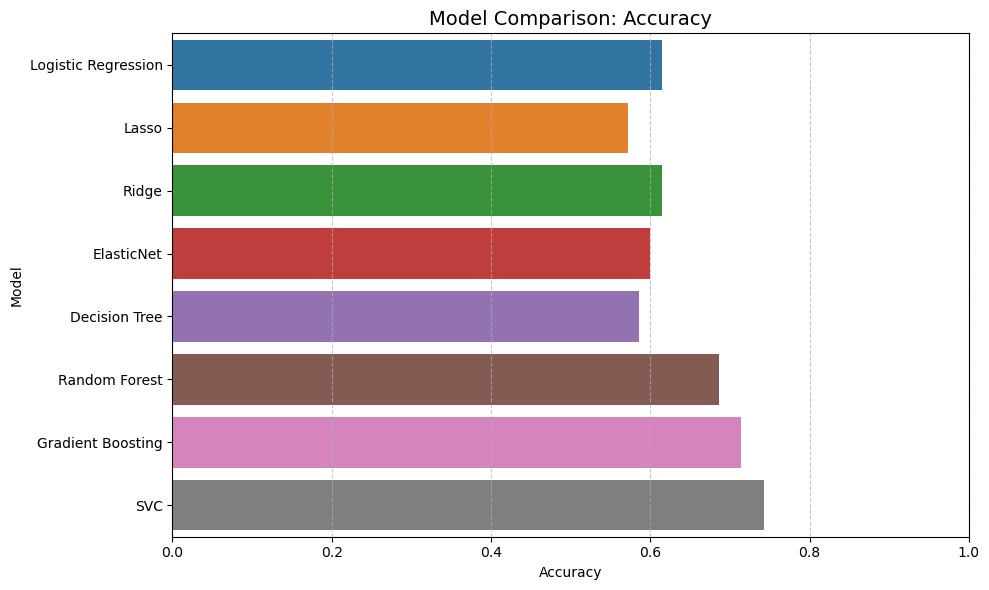

In [196]:
################################################################
## Plotting the R2_score for all the models and choose the best
################################################################

model_names = ['Logistic Regression', 'Lasso', 'Ridge', 'ElasticNet', 'Decision Tree',
               'Random Forest', 'Gradient Boosting', 'SVC']

accuracy = [accuracy_mult, accuracy_lasso, accuracy_ridge, accuracy_enet, accuracy_dt, 
            accuracy_rf, accuracy_gb, accuracy_svc]


# Build long-form dataframe
metrics_df = pd.DataFrame({
    'Model': model_names ,
    'Accuracy': accuracy        
})
print(metrics_df)

# Plot grouped bar chart
plt.figure(figsize=(10, 6))
sns.barplot(data=metrics_df, x='Accuracy', y='Model')
plt.title('Model Comparison: Accuracy', fontsize=14)
plt.xlabel('Accuracy')
plt.xlim(0, 1)
plt.ylabel('Model')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('Model performance (multicategorical target variable).png')
plt.show()
